# Classifying YouTube Comments With Differentially Private Gradient Descent

Using a collection of over 1000 Youtube comments from popular videos, I will try to differentiate between spam and non-spam using a logistic regression model, gradient descent, and differentially private gradient descent. Once each model has been trained, I will compare the results

Comments that are advertising for another channel, video, or website are considered spam

In [1]:
#import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression
# I like to use train_test_split to make the data split easier
from sklearn.model_selection import train_test_split
# This is used to count words
from sklearn.feature_extraction.text import CountVectorizer
# this will help compare the performance of each model
from sklearn.metrics import accuracy_score, confusion_matrix

#used to make the noisy gradient in dp gradient descent
def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]
#used to make the noisy size in dp gradient descent
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)


#load in the data
#a sample of 350 random comments from 3 popular videos
data1 = pd.read_csv('Youtube01-Psy.csv')
data2 = pd.read_csv('Youtube02-KatyPerry.csv')
data3 = pd.read_csv('Youtube04-Eminem.csv')
#put the data into one frame
data = pd.concat([data1,data2,data3],ignore_index = True)
#the prediction function used in class works on classification values of -1 and 1.
#this data uses 0 and 1
#to make this data work with the prediction function, I changed the values to -1 and 1
for i in range(data.shape[0]):
    if data.iloc[i,4]==0:
        data.iloc[i,4]=-1
#show the data
data

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1
...,...,...,...,...,...
1143,LneaDw26bFu3RCmyrWyP9S6wh1h9dBv3X95g1HzKAb4,Dany PK,NaN,SUBSCRIBE TO MY CHANNEL X PLEASE!. SPARE,1
1144,LneaDw26bFsD65dtIvAEObWYIYnFTqQDKBek_Ypz3J8,SmexyFriedChicken,NaN,Check out my videos guy! :) Hope you guys had ...,1
1145,LneaDw26bFuvs-8oWkLpAFa6g3QHpWD8k7sbbMP3Bg8,The Guy That's Done Everything,NaN,3 yrs ago I had a health scare but thankfully ...,1
1146,z12hfp2wmyuqztkw504cgblyxtbsxjuzeow0k,Jesse Pinkman,2015-05-06T11:42:44.601000,Rihanna looks so beautiful with red hair ;)﻿,-1


# Logistic Regression Model

Starting with the prebuilt sklearn model, and using the 'bag-of-words' method to turn the comment content into workable features

In [3]:
#the only feature that I am using is the comment itself
X = data.iloc[:,3]
y = data.iloc[:,-1]

#logistic regression cannot work with a string
#so I used this to count how many times each word appears in a new comment
#each time a word is used, 1 gets added to that words column
#if the word is appearing for the first time, a new column gets added
#one feature becomes just over 3500 features, stored in a sparse matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)
#but then turn it into an array so that it can be worked with easily further down the line
X = X.toarray()


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .25, random_state = 0)
print("Shape of Data: " + str(X.shape))

Shape of Data: (1148, 3525)


In [4]:
model = LogisticRegression().fit(X_train,y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9372822299651568


This model produces incredibly accurate results

In [5]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_frame = pd.DataFrame(data = conf_mat)
conf_mat_frame.rename(columns={0:'Predicted Normal',1:'Predicted Spam'}, index={0:'True Normal',1:'True Spam'})

,Predicted Normal,Predicted Spam
True Normal,128,2
True Spam,16,141


As you can see in the confusion matrix above, this model shows promising results on the data, with high rates of true-positives and true-negatives

# Gradient Descent

Now for plain gradient descent, using the functions from class. The predict function had to be slightly modified, it kept predicting a third class, 0, rather than -1 or 1. I beleive that this was most likely due to the amount of 0's in the training and testing data. Because every word is not used in every comment, many samples might have only a handful of columns that actually contain data, while the remaing thousands of columns only contain 0's

I also added learning rate(eta) to the gradient descent function, to try and fine tune the results

In [6]:
def loss(theta, xi, yi):
    exponent = - yi * (xi.dot(theta))
    return np.log(1 + np.exp(exponent))


def gradient(theta, xi, yi):
    exponent = yi * (xi.dot(theta))
    return - (yi*xi) / (1+np.exp(exponent))

def avg_grad(theta, X, y):
    list_of_gradients = [gradient(theta, x_i, y_i) for x_i, y_i in zip(X,y)]
    return np.mean(list_of_gradients, axis = 0)

def gradient_descent(iterations):
    theta = np.zeros(X_train.shape[1])
    for i in range(iterations):
        avg_gradient = avg_grad(theta, X_train, y_train)
        theta = theta - (avg_gradient)
    return theta

def predict(xi, theta, bias=0):
    label = np.sign(xi @ theta + bias)
    #predict sometimes returns a 0 rather than -1 or 1
    for i in range(len(label)):
        #if it tries to predict a 0
        if label[i] == 0:
            #flip it to a -1
            label[i] = -1
            #im not sure if this is the correct way to handle something like this, as it will change the 
            #outcome, but it seemed better to assume that an indeterminate comment is not spam
    return label

def accuracy(theta):
    return np.sum(predict(X_test, theta) == y_test)/X_test.shape[0]


In [7]:
GD_results = []
#1 iteration
theta = gradient_descent(1)
print("Gradient Descent Accuracy: " + str(accuracy(theta)))
GD_results.append(accuracy(theta))
print(theta)

#10 iterations
theta = gradient_descent(10)
print("Gradient Descent Accuracy: " + str(accuracy(theta)))
GD_results.append(accuracy(theta))
print(theta)

#20 iterations
theta = gradient_descent(20)
GD_results.append(accuracy(theta))


#30 iterations
theta = gradient_descent(30)
GD_results.append(accuracy(theta))


#60 iterations. I found this to produce the best results
#anything more decreased accuracy, most likely due to overfitting
theta = gradient_descent(60)
print("Gradient Descent Accuracy: " + str(accuracy(theta)))
GD_results.append(accuracy(theta))
print(theta)



Gradient Descent Accuracy: 0.7386759581881533
[ 0.00116144 -0.00232288 -0.00058072 ...  0.          0.
  0.        ]
Gradient Descent Accuracy: 0.8710801393728222
[ 0.00310332 -0.06172613 -0.00493127 ...  0.          0.
  0.        ]
Gradient Descent Accuracy: 0.9128919860627178
[ 0.02254858 -0.27292906 -0.01623813 ...  0.          0.
  0.        ]


Gradient descent with 60 iterations seems to produce the best results, and is nearly as accurate as the sklearn model used above

In [8]:
y_pred = predict(X_test, theta)

conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_frame = pd.DataFrame(data = conf_mat)
conf_mat_frame.rename(columns={0:'Predicted Normal',1:'Predicted Spam'}, index={0:'True Normal',1:'True Spam'})

,Predicted Normal,Predicted Spam
True Normal,119,11
True Spam,14,143


The results are not identical to the results of the logistic regression model, but gradient descent still has very high ratios of true positives and negatives

# Differentially Private Gradient Descent

Finally, I will use the vectorized gaussian function, L2 clipping, and the functions from plain gradient descent to classify the comments with gradient descent that satisfies $(\epsilon, \delta)$ - differential privacy using sequential composition

In [9]:
#DP gradient descent functions
#this function is used to bound the L2 sensitivity
def L2_clip(v, b):
    #Find the vector v's L2 norm
    norm = np.linalg.norm(v, ord=2)
    if norm > b:
        #divide v by its l2 norm, scale it back up to param b
        return b * (v / norm)
    else:
        return v

    
def gradient_sum(theta, X, y, b):
    #gradient is found by using plain GD gradient function, then L2 clipping it
    gradients = [L2_clip(gradient(theta, x_i, y_i), b) for x_i, y_i in zip(X,y)]
    #return the sum of the L2 clipped gradient
    return np.sum(gradients, axis=0)

    
def noisy_gradient_descent(iterations, epsilon, delta):
    theta = np.zeros(X_train.shape[1])
    #clipping param
    b = 4
    #epsilon is divided by iterations+1, because it is used iterations+1 times.
    #by doing this we ensure epsilon/delta DP through sequential comp
    epsilon_i = epsilon/(iterations+1)
    #same is done to delta, it is only used iterations #of times
    delta_i = delta/iterations
    #counting query, laplace mech is used to add noise
    dataset_size = len(X_train)
    #epsilon is used 1 time here
    noisy_size = laplace_mech(dataset_size, 1, epsilon_i)
    for i in range(iterations):
        #get the gradient sum using gradient sum function above
        grad_sum = gradient_sum(theta, X_train, y_train, b)
        #add noise to the gradient sum using vectorized gaussian mechanism
        noisy_grad_sum = gaussian_mech_vec(grad_sum, b, epsilon_i, delta_i)
        #avg gradient is found here by dividing the noisy gradient sum by the noisy size of the dataset
        noisy_avg_grad = np.array(noisy_grad_sum) / noisy_size
        #update theta
        theta = theta - noisy_avg_grad
    return theta

In [11]:
DPGD_results = []
#for comparison, ive included calls with the same iterations
theta = noisy_gradient_descent(1, 1.0, 1e-5)
print("DP Gradient Descent Accuracy: " + str(accuracy(theta)))
DPGD_results.append(accuracy(theta))
print(theta)

#10 iterations
theta = noisy_gradient_descent(10, 1.0, 1e-5)
print("DP Gradient Descent Accuracy: " + str(accuracy(theta)))
DPGD_results.append(accuracy(theta))
print(theta)

#20 iterations
theta = noisy_gradient_descent(20, 1.0, 1e-5)
DPGD_results.append(accuracy(theta))


#30 iterations
theta = noisy_gradient_descent(30, 1.0, 1e-5)
DPGD_results.append(accuracy(theta))


theta = noisy_gradient_descent(60, 1.0, 1e-5)
print("Gradient Descent Accuracy: " + str(accuracy(theta)))
DPGD_results.append(accuracy(theta))
print(theta)

DP Gradient Descent Accuracy: 0.6968641114982579
[-0.00616075  0.00475035 -0.03210255 ...  0.04353764  0.00467656
  0.04483389]
DP Gradient Descent Accuracy: 0.5749128919860628
[ 0.50820622 -1.12441671  0.04407067 ... -1.03262445 -0.45489567
 -0.38251876]
Gradient Descent Accuracy: 0.578397212543554
[ -5.38765466 -21.95125115   2.41446005 ...   5.36713486   9.61606424
 -13.95324515]


Results are all worse than their plain gradient descent counterparts. This is most likely due to the scale of the noise and number of iterations. To satisfy $(\epsilon, \delta)$ - differenial privacy, DP gradient descent is using $\epsilon$/iterations per iteration, resulting in a very small epsilon for high iterations. A high number of iterations also allows for DP gradient descent to easily start to converge in the wrong direction, which returns poor results.

In [12]:
y_pred = predict(X_test, theta)

conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_frame = pd.DataFrame(data = conf_mat)
conf_mat_frame.rename(columns={0:'Predicted Normal',1:'Predicted Spam'}, index={0:'True Normal',1:'True Spam'})

,Predicted Normal,Predicted Spam
True Normal,60,70
True Spam,51,106


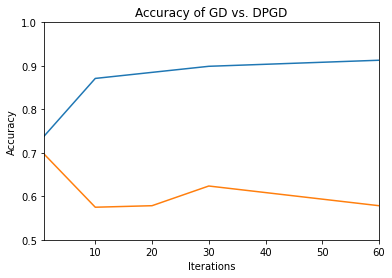

In [13]:
#plot GD vs DPGD results
iterations = [1,10,20,30,60]
plt.plot(iterations,GD_results)
plt.plot(iterations,DPGD_results)
plt.axis([1,60,.5,1])
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('Accuracy of GD vs. DPGD')
plt.show()

To try to get slightly better results, I will use a higher epsilon. This will have a higher privacy cost, but will return better results

In [14]:
DPGD_results = []
#for comparison, ive included calls with the same iterations
theta = noisy_gradient_descent(1, .2, 1e-5)
print("DP Gradient Descent Accuracy: " + str(accuracy(theta)))
DPGD_results.append(accuracy(theta))
print(theta)

#10 iterations
theta = noisy_gradient_descent(10, 1.1, 1e-5)
print("DP Gradient Descent Accuracy: " + str(accuracy(theta)))
DPGD_results.append(accuracy(theta))
print(theta)

#20 iterations
theta = noisy_gradient_descent(20, 2.1, 1e-5)
DPGD_results.append(accuracy(theta))


#30 iterations
theta = noisy_gradient_descent(30, 3.1, 1e-5)
DPGD_results.append(accuracy(theta))


theta = noisy_gradient_descent(60, 6.1, 1e-5)
print("Gradient Descent Accuracy: " + str(accuracy(theta)))
DPGD_results.append(accuracy(theta))
print(theta)

DP Gradient Descent Accuracy: 0.5296167247386759
[ 0.35372438  0.01923432 -0.11506424 ...  0.04729125  0.23611801
 -0.22149269]
DP Gradient Descent Accuracy: 0.6585365853658537
[ 1.36511916 -0.11419661 -0.689384   ... -0.90675023 -0.42137875
 -0.49376371]
Gradient Descent Accuracy: 0.6933797909407665
[ 1.09520325 -0.98836692  1.02094254 ...  2.88590674 -0.18955061
 -0.557409  ]


In [15]:
y_pred = predict(X_test, theta)

conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_frame = pd.DataFrame(data = conf_mat)
conf_mat_frame.rename(columns={0:'Predicted Normal',1:'Predicted Spam'}, index={0:'True Normal',1:'True Spam'})

,Predicted Normal,Predicted Spam
True Normal,67,63
True Spam,25,132


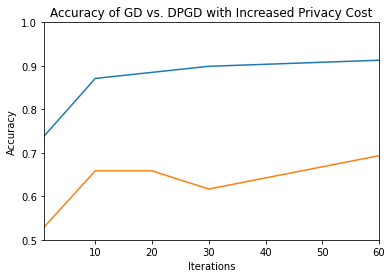

In [16]:
#plot the results with updated final result, should show an improvement
iterations = [1,10,20,30,60]
plt.plot(iterations,GD_results)
plt.plot(iterations,DPGD_results)
plt.axis([1,60,.5,1])
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('Accuracy of GD vs. DPGD with Increased Privacy Cost')
plt.show()

Raising the privacy cost improves results, accuracys mirror plain gradient descent.

Microsoft Stream Video : https://web.microsoftstream.com/video/9b8bb6db-1f6d-42ff-8fa5-dcb2d2f1a60b